In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import shelve
import numpy as np
from copy import deepcopy

# SOLETE: 
1. Resolution: 1sec, 1min, 5min, 60min
2. Features: ['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]', 'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'P_Solar[kW]', 'Pressure[mbar]', 'Azimuth[deg]', 'Elevation[deg]']


In [ ]:
resolutions = {
    1: "SOLETE_clean_1sec.csv",
    60: "SOLETE_clean_1min.csv",
    300: "SOLETE_clean_5min.csv",
    3600: "SOLETE_clean_60min.csv"
}
# resolutions = {
#     1: "SOLETE_Pombo_1sec.h5",
#     60: "SOLETE_Pombo_1min.h5",
#     300: "SOLETE_Pombo_5min.h5",
#     3600: "SOLETE_Pombo_60min.h5"
# }
pth = "SOLETE_data"

# Solar
# cols = ['TEMPERATURE[degC]', 'POA Irr[kW1m2]', 'P_Solar[kW]']

# Wind
# cols = ['WIND_SPEED[m1s]', 'P_Gaia[kW]', 'WIND_DIR[deg]']

cols = ['WIND_SPEED[m1s]', 'TEMPERATURE[degC]']

# fig, axs = plt.subplots(len(resolutions), figsize=[20, 15])
for i, r in enumerate(resolutions):
    print(r)
    df = pd.read_hdf(os.path.join(pth, resolutions[r]))
    df = df.sort_index()
    # df = df["2018-09-01":"2018-10-30"]
    # df[cols].plot(ax=axs[i], secondary_y=cols[-1]/)
    resolutions[r] = df
# fig.tight_layout()

In [ ]:
def three_sigma(Ser1):
    '''
    3 sigma standard
    '''
    rule = (Ser1.mean() - 3 * Ser1.std() >
            Ser1) | (Ser1.mean() + 3 * Ser1.std() < Ser1)
    index = Ser1[rule].index
    return index


# cols = ['WIND_SPEED[m1s]', 'TEMPERATURE[degC]']
resolutions = {
    1: "SOLETE_clean_1sec.csv",
    60: "SOLETE_clean_1min.csv",
    300: "SOLETE_clean_5min.csv",
    3600: "SOLETE_clean_60min.csv"
}
pth = "SOLETE_data"
cols = ['TEMPERATURE[degC]']
# cols = ['WIND_SPEED[m1s]', 'TEMPERATURE[degC]', 'WIND_DIR[deg]','P_Gaia[kW]']
fig, axs = plt.subplots(len(resolutions), figsize=[20, 15])
for i, r in enumerate(resolutions):
    # df = resolutions[r]
    df = pd.read_csv(os.path.join(pth, resolutions[r]),
                     index_col=0,
                     parse_dates=True,
                     infer_datetime_format=True)
    # 1-diff
    df_delta_pos = (df - df.shift(1))[cols].dropna()
    df_delta_neg = (df.shift(-1) - df)[cols].dropna()
    for c in cols:
        outlier_idx_pos = three_sigma(df_delta_pos[c])
        outlier_idx_neg = three_sigma(df_delta_neg[c])
        outlier_idx = outlier_idx_pos.intersection(outlier_idx_neg)
        # df[c].plot(ax=axs[i])
        df.loc[outlier_idx_neg, c] = np.nan
        df[c] = df[c].interpolate(limit_direction='both', kind='quadratic')

    # axs[i].scatter(outlier_idx, df_delta_pos.loc[outlier_idx, cols[0]])
    # axs[i].plot(df_delta_pos.loc[:, cols[0]])
    # axs[i].plot(df_delta_pos.loc[:, cols[0]].index, np.repeat(df_delta_pos.loc[:, cols[0]].mean()- df_delta_pos.loc[:, cols[0]].std()*3, len(df_delta_pos)) )
    # axs[i].plot(df_delta_pos.loc[:, cols[0]].index, np.repeat(df_delta_pos.loc[:, cols[0]].mean()+ df_delta_pos.loc[:, cols[0]].std()*3, len(df_delta_pos)) )

    # df.to_csv(os.path.join(pth, "new_"+resolutions[r]))
    resolutions[r] = df
fig.tight_layout()


In [ ]:
# fig, axs = plt.subplots(len(resolutions), figsize=[20, 15])
names = [
    "SOLETE_clean_1sec.csv",
    "SOLETE_clean_1min.csv",
    "SOLETE_clean_5min.csv",
    "SOLETE_clean_60min.csv",
]
for i, r in enumerate(resolutions):
    print(r)
    df = resolutions[r]
    df["MATH_DIR[deg]"] = 270 - df["WIND_DIR[deg]"]
    df["u"] = df["WIND_SPEED[m1s]"] * np.cos(
        df["MATH_DIR[deg]"] * np.pi / 180.0)
    df["v"] = df["WIND_SPEED[m1s]"] * np.sin(
        df["MATH_DIR[deg]"] * np.pi / 180.0)
    df.to_csv(os.path.join(pth, names[i]))

Normalization

In [ ]:
from datasets.Functions import import_PV_WT_data, PV_Performance_Model


def logit_normalise(df, cols, order=1):
    for c in cols:
        df[c + "[pu]"] = df[c] / (df[c].max() + 0.001)
        df[c + "-LNT"] = np.log(df[c + "[pu]"]**order /
                                (1 - df[c + "[pu]"]**order))
    return df


resolutions = {
    1: "SOLETE_clean_1sec.csv",
    60: "SOLETE_clean_1min.csv",
    300: "SOLETE_clean_5min.csv",
    3600: "SOLETE_clean_60min.csv"
}
pth = "datasets"
cols = ['u', 'v', 'P_Gaia[kW]']
v = 1
# cols = ['TEMPERATURE[degC]','POA Irr[kW1m2]','P_Solar[kW]']
info = import_PV_WT_data()
# fig, axs = plt.subplots(len(resolutions), figsize=[20, 15])
for i, r in enumerate(resolutions):

    # Skip 1sec, too large
    if i == 0 or i == 1:
        continue

    df = pd.read_csv(os.path.join(pth, resolutions[r]),
                     index_col=0,
                     parse_dates=True,
                     infer_datetime_format=True)
    df = df['2018-08':'2019-05']
    print(len(df[df["P_Gaia[kW]"] <= 0.0]))

    # Normalise the data
    df['Pac'], df['Pdc'], df['TempModule'], df[
        'TempCell'] = PV_Performance_Model(df, info[0])
    df['P_Solar[kW]'] = np.where(df['Pac'] >= 1.5 * df['P_Solar[kW]'],
                                 df['Pac'], df['P_Solar[kW]'])
    df['P_Gaia[kW]'] = np.where(df['P_Gaia[kW]'] <= 0.0, 0.001,
                                df['P_Gaia[kW]'])
    df['P_Sythetic[kW]'] = np.where(df['P_Sythetic[kW]'] <= 0.0, 0.001,
                                    df['P_Sythetic[kW]'])
    df = logit_normalise(df,
                         cols=['P_Gaia[kW]', 'P_Sythetic[kW]', 'P_Solar[kW]'])
    # print(df.columns.tolist())
    # # df['P_Gaia_GLNT[pu]'] = 1 / np.sqrt(2 * np.pi) * v / (
    # #     df['P_Gaia[pu]'] *
    # #     (1 - df['P_Gaia[pu]']**v)) * np.exp(-0.5 * df['P_Gaia_LNT[pu]']**2)
    # # df['P_Solar_GLNT[pu]'] = 1 / np.sqrt(2 * np.pi) * v / (
    # #     df['P_Solar[pu]'] *
    # #     (1 - df['P_Solar[pu]']**v)) * np.exp(-0.5 * df['P_Solar_LNT[pu]']**2)

    # df.to_csv(os.path.join(pth, resolutions[r]))
    df.plot(y=['P_Sythetic[kW]'], kind="hist", bins=50)
    df.plot(y=['P_Sythetic[kW]-LNT'], kind="hist", bins=50)
    df.plot(y=['P_Gaia[kW]'], kind="hist", bins=50)
    df.plot(y=['P_Gaia[kW]-LNT'], kind="hist", bins=50)
    # resolutions[r] = df
    # break
    # df[cols].plot(ax=axs[i], secondary_y=cols[-1])
# fig.tight_layout()


Make synthetic wind power data

In [ ]:
R_d = 287.058
R_v = 461.495
R = info[1]["D"] / 2
cin = info[1]["Cin"]
cout = info[1]["Cout"]
print(R)


def make_synthetic_wind_power(df):
    p_1 = 6.1078 * np.power(
        10, 7.5 * df["TEMPERATURE[degC]"] / (df["TEMPERATURE[degC]"] + 237.3))
    p_v = p_1 * df["HUMIDITY[%]"]
    p_d = df["Pressure[mbar]"] * 100 - p_v
    print(df["Pressure[mbar]"].max())
    print(df["Pressure[mbar]"].min())
    air_density = p_d / (R_d * (df["TEMPERATURE[degC]"] + 273.15)) + p_v / (
        R_v * (df["TEMPERATURE[degC]"] + 273.15))
    print(air_density.max())
    print(air_density.min())
    # ws = np.where(df["WIND_SPEED[m1s]"])
    synthetic_wind = 0.5 * np.pi * R**2 * df[
        "WIND_SPEED[m1s]"]**3 * air_density * 0.001
    synthetic_wind = np.where(df["WIND_SPEED[m1s]"] < cin, 0, synthetic_wind)
    synthetic_wind = np.where(df["WIND_SPEED[m1s]"] > cout, 0, synthetic_wind)
    return synthetic_wind


resolutions = {
    1: "SOLETE_clean_1sec.csv",
    60: "SOLETE_clean_1min.csv",
    300: "SOLETE_clean_5min.csv",
    3600: "SOLETE_clean_60min.csv"
}
for i, r in enumerate(resolutions):
    # Skip 1sec, too large
    if i == 0:
        continue
    df = pd.read_csv(resolutions[r],
                     index_col=0,
                     parse_dates=True,
                     infer_datetime_format=True)
    # df = resolutions[r]
    # p_1 = 6.1078 * np.power(
    #     10, 7.5 * df["TEMPERATURE[degC]"] / (df["TEMPERATURE[degC]"] + 237.3))
    # p_v = p_1 * df["HUMIDITY[%]"]
    # p_d = df["Pressure[mbar]"] * 100 - p_v
    # print(df["Pressure[mbar]"].max())
    # print(df["Pressure[mbar]"].min())
    # air_density = p_d / (R_d * (df["TEMPERATURE[degC]"] + 273.15)) + p_v / (
    #     R_v * (df["TEMPERATURE[degC]"] + 273.15))
    # print(air_density.max())
    # print(air_density.min())
    # # ws = np.where(df["WIND_SPEED[m1s]"])
    # synthetic_wind = 0.5 * np.pi * R**2 * df["WIND_SPEED[m1s]"]**3 * air_density * 0.001
    # synthetic_wind = np.where(synthetic_wind < cin, synthetic_wind*0.67, synthetic_wind)
    df["P_Sythetic(kW)"] = make_synthetic_wind_power(df)
    print(df.columns.tolist())
    df.to_csv(resolutions[r])
    resolutions[r] = df
    # df['2018-08':'2019-05'].plot(x="P_Sythetic(kW)",y="P_Gaia[kW]", kind="scatter")

    # break


simple plot

In [ ]:
df = pd.read_csv("datasets/SOLETE_clean_5min.csv",
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format=True)
df = df['2018-08-13':'2018-08-16']
df.plot(y=["P_Gaia[kW]", "P_Sythetic[kW]"])


Freq domain

In [ ]:
# df = pd.read_csv("datasets/SOLETE_clean_1min.csv")["P_Gaia[kW]"].values.flatten()
df = pd.read_csv(
    "datasets/SOLETE_clean_1min.csv")["P_Solar[kW]"].values.flatten()
from scipy.fft import fft, fftfreq
import numpy as np
# Number of sample points
N = len(df)
# sample spacing
T = 1 / 60 / 24
x = np.linspace(0.0, N * T, N, endpoint=False)
y = df
yf = fft(y)
xf = fftfreq(N, T)[:N // 160]
import matplotlib.pyplot as plt

plt.plot(xf, 2.0 / N * np.abs(yf[0:N // 160]))
plt.grid()
plt.show()

Windspeed-Power curve

/tmp/ipykernel_449540/1523916650.py:18: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(f"datasets/SOLETE_clean_{res}.csv",


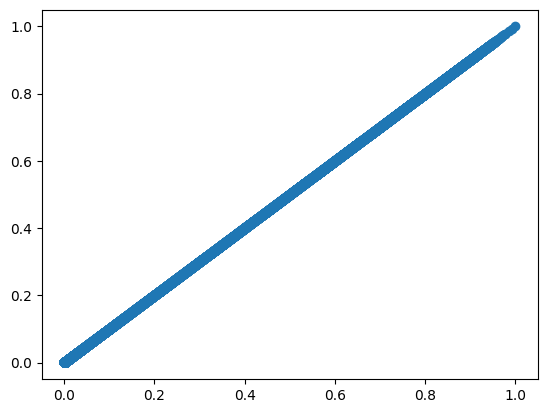

In [11]:
from datasets.Functions import import_PV_WT_data
from scipy.interpolate import CubicSpline


def logit_normalise(df, cols, order=1):
    for c in cols:
        df[c] = np.where(df[c] <= 0, 0.001, df[c])
        df[c + "[pu]"] = df[c] / (df[c].max() + 0.001)
        df[c + "-LNT"] = np.log(df[c + "[pu]"]**order /
                                (1 - df[c + "[pu]"]**order))
    return df

def inverse_logit_transform(data, order=1):
    out = (1 + 1 / np.exp(data)) ** (-1/order)
    # out = np.power(out, -1 / order)
    return out
res = "5min"
df = pd.read_csv(f"datasets/SOLETE_clean_{res}.csv",
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format=True)

tem = 270 - df["WIND_DIR[deg]"]
df["u"] = np.cos(tem / 180 * np.pi)
df["v"] = np.sin(tem / 180 * np.pi)
_, WT = import_PV_WT_data()
ws = np.array([0.0, 1.0, 2.0] + WT["CWs"])
wp = np.array([0.0, 0.0, 0.0] + WT["CP"])

# fig,ax=plt.subplots()
# ax.scatter(df["WIND_SPEED[m1s]"],df["P_Gaia[kW]"], alpha=0.05, label="measured")
# ax.plot(ws,wp,c="C1", label="given")
# ax.set_xlabel("wind speed")
# ax.set_ylabel("wind power")
# ax.legend()


cs = CubicSpline(ws, wp)
# cs = lambda x: np.interp(x,WT["CWs"], WT["CP"])
y = cs(df["WIND_SPEED[m1s]"])
y = np.where(y < 0, 0.001, y)
df["P_synthetic[kW]"] = y
df = logit_normalise(
    df,
    cols=["P_Gaia[kW]", "P_synthetic[kW]", "P_Solar[kW]"],
    order=1)

inverse_wind = inverse_logit_transform(df["P_Gaia[kW]-LNT"])
plt.scatter(inverse_wind, df["P_Gaia[kW][pu]"])



# idx = slice(2000, 6000)
# cols = [
#     "P_synthetic[kW]", "P_synthetic[kW]-LNT", "P_Gaia[kW]", "P_Gaia[kW]-LNT"
# ]
# fig, axs = plt.subplots(len(cols), sharex=True, figsize=[12, 8])
# for i, c in enumerate(cols):
#     axs[i].plot((df.index[idx]), df[c].values[idx])
#     axs[i].set(title=c)
# fig.tight_layout()

# cols = ["WIND_SPEED[m1s]", "WIND_DIR[deg]", "u", "v"]
# # cols = ["WIND_SPEED[m1s]", "WIND_SPEED[m1s]-LNT", "u", "u-LNT", "v", "v-LNT", "WIND_DIR[deg]"]
# fig, axs = plt.subplots(len(cols), sharex=True, figsize=[12, 10])
# for i, c in enumerate(cols):
#     axs[i].plot(df.index[idx], df[c].values[idx])
#     axs[i].set(title=c)
# fig.tight_layout()

# df.to_csv(f"datasets/SOLETE_new_{res}.csv")

ACF, PACF, Hist

/tmp/ipykernel_180148/852780921.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(f"datasets/SOLETE_new_{res}.csv",


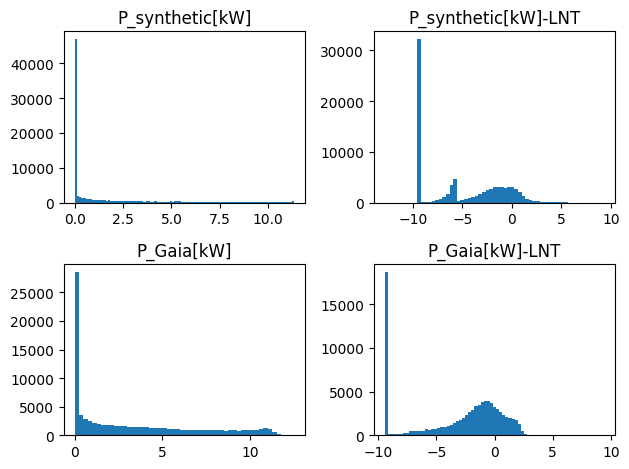

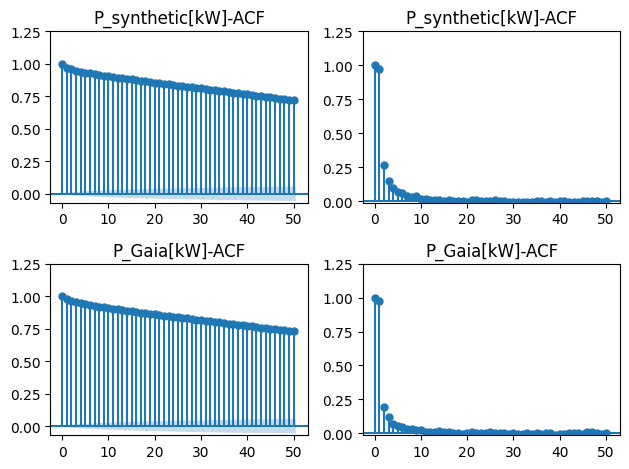

In [9]:
res = "5min"
df = pd.read_csv(f"datasets/SOLETE_new_{res}.csv",
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format=True)
df = df['2018-08':'2019-05']
cols = [
    "P_synthetic[kW]", "P_synthetic[kW]-LNT", "P_Gaia[kW]", "P_Gaia[kW]-LNT"
]
fig, axs = plt.subplots(len(cols)//2, 2)
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].hist(df[cols[i]], bins='auto')
    axs[i].set(title=cols[i])
    axs[i].autoscale(enable=True)
fig.tight_layout()

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

cols = [
    "P_synthetic[kW]", "P_Gaia[kW]"
]
fig, axs = plt.subplots(len(cols), 2)
# axs = axs.ravel()
for i in range(len(cols)):
    # axs[i].hist(df[cols[i]], bins='auto')
    # axs[i].set(title=cols[i])
    # axs[i].autoscale(enable=True)
    plot_acf(df[cols[i]], ax=axs[i, 0], auto_ylims=True, title=cols[i]+"-ACF")
    plot_pacf(df[cols[i]], ax=axs[i, 1], auto_ylims=True, title=cols[i]+"-ACF")

fig.tight_layout()


Detrend with low-resolution data

/tmp/ipykernel_491030/3655306547.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_5min = pd.read_csv("datasets/SOLETE_new_5min.csv",


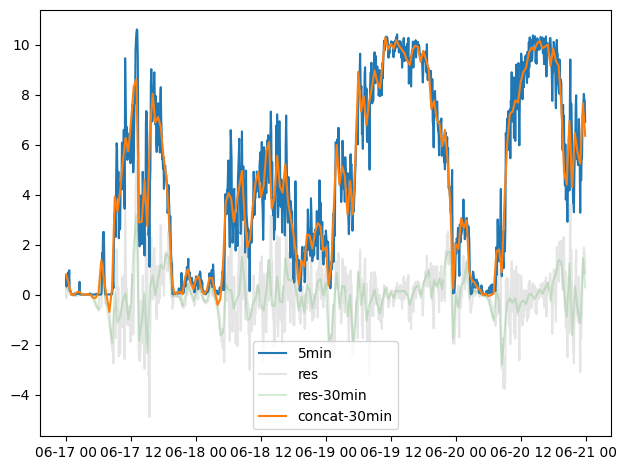

In [12]:
feature = ["P_Gaia[kW]"]
# feature = ["P_Solar[kW]"]
df_5min = pd.read_csv("datasets/SOLETE_new_5min.csv",
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format=True)[feature]
# df_1hr_real = pd.read_csv("datasets/SOLETE_new_60min.csv",
#                  index_col=0,
#                  parse_dates=True,
#                  infer_datetime_format=True)[feature]
df_1hr = df_5min.resample('60min').mean()
df_1hr = df_1hr.resample('5min').mean()
df_1hr = df_1hr.interpolate()

res = df_5min - df_1hr
df_res = res.resample('30min').mean()
df_res = df_res.resample('5min').mean()
df_res = df_res.interpolate()

df_10min = df_5min.resample('30min').mean()
df_10min = df_10min.resample('5min').mean()
df_10min = df_10min.interpolate()

fig, ax = plt.subplots()
ax.plot(df_5min["2018-06-17":"2018-06-20"],label="5min")
# ax.plot(df_1hr["2018-06-17":"2018-06-20"],label="1hr")
# ax.plot(df_1hr_real["2018-06-16":"2018-06-30"],label="1hr-real")
ax.plot(df_5min["2018-06-17":"2018-06-20"]-df_1hr["2018-06-17":"2018-06-20"],label="res",c="grey",alpha=0.2)
ax.plot(df_res["2018-06-17":"2018-06-20"],label="res-30min",alpha=0.2, c="C2")
ax.plot(df_res["2018-06-17":"2018-06-20"] + df_1hr["2018-06-17":"2018-06-20"],label="concat-30min")
# ax.plot(df_5min["2018-06-17":"2018-06-20"] - df_res["2018-06-17":"2018-06-20"] - df_1hr["2018-06-17":"2018-06-20"],label="res-30min", alpha=0.2)
# ax.plot(df_10min["2018-06-17":"2018-06-20"],label="real-10min")
ax.legend()
fig.tight_layout()

In [ ]:
feature = ["P_Gaia[kW]"]
# feature = ["P_Solar[kW]"]
df_5min = pd.read_csv("datasets/SOLETE_new_5min.csv",
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format=True)[feature]
window_size = 12 * 24
i = 0
while (i + window_size) < len(df_5min):
    

    i+=1